# Prediction challenge

### Predict the demand for the bike-sharing system (number of dropoffs and pickups)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

f=pd.read_csv("../data/Trips_2018.csv")


In [2]:
# step 1: customize the data table

print(f.dtypes)

f.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
f['starttime']=pd.to_datetime(f['starttime'], format="%Y-%m-%d %H:%M:%S.%f")
f['stoptime']=pd.to_datetime(f['stoptime'], format="%Y-%m-%d %H:%M:%S.%f")
f['usertype']=pd.Categorical(f['usertype'])
f['gender']=pd.Categorical(f['gender'])
f['start_station_id']=pd.Categorical(f['start_station_id'])
f['end_station_id']=pd.Categorical(f['end_station_id'])

bad_idx = f.index[f.isna().any(axis=1)]
print(bad_idx.tolist())
rows_with_na = f[f.isna().any(axis=1)]
print("rows_with_na first", rows_with_na)

f = f.dropna()

print(f.dtypes)
print(f)

Unnamed: 0                   int64
tripduration                 int64
starttime                   object
stoptime                    object
start_station_id           float64
start_station_latitude     float64
start_station_longitude    float64
end_station_id             float64
end_station_latitude       float64
end_station_longitude      float64
bikeid                       int64
usertype                    object
birth_year                   int64
gender                       int64
dtype: object
[10413518, 10413697, 10415434, 10415668, 10417031, 10417714, 10417770, 10421216, 10421276, 10422411, 10422596, 10422885, 10422892, 10423047, 10423230, 10423232, 10423388, 10423461, 10423832, 10423867, 10423879, 10423981, 10424026, 10424117, 10424185, 10424278, 10424294, 10424452, 10424591, 10425255, 10425520, 10425626, 10425772, 10426135, 10426607, 10427815, 10427993, 10428027, 10428296, 10428504, 10428784, 10428794, 10430531, 10433528, 10436246, 10438241, 10440685, 10443234, 10444360, 10444

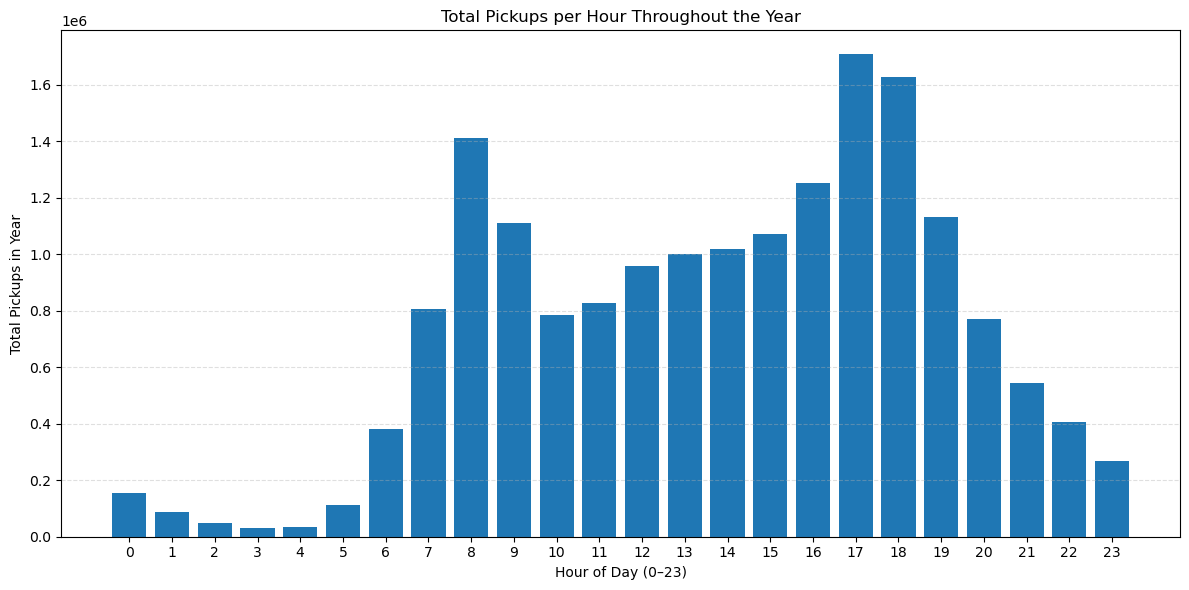

In [3]:
# Start by ploting the total pickup for each hour througout the year
# create an hour column
f['hour'] = f['starttime'].dt.hour

# --- Compute total pickups per hour ---
hourly_counts = f.groupby('hour').size()

# Ensure all 24 hours exist
hourly_counts = hourly_counts.reindex(range(24), fill_value=0)

# --- Plot ---
plt.figure(figsize=(12,6))
plt.bar(hourly_counts.index, hourly_counts.values)
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Total Pickups in Year")
plt.title("Total Pickups per Hour Throughout the Year")
plt.xticks(range(24))
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

1) Cluster the stations spatially (nearby departing stations should be grouped together)
in no less than 20 clusters. Tasks 2 and 3 will be based on this clustering, and they
should be completed for at least two clusters (more is preferable) so that you can
compare their respective results and discuss them

In [4]:
from sklearn.cluster import KMeans

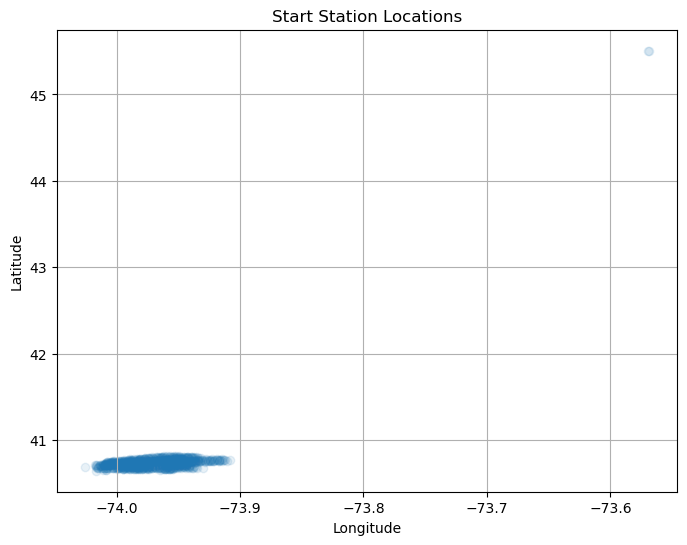

In [5]:
# Create a new DataFrame with start station ID and coordinates, then plot the locations
f_cluster = f[['start_station_id', 'start_station_latitude', 'start_station_longitude', 'end_station_id']]
f_cluster = f_cluster.drop_duplicates(subset='start_station_id')


plt.figure(figsize=(8, 6))
plt.scatter(f_cluster['start_station_longitude'], f_cluster['start_station_latitude'], alpha=0.1)

plt.title('Start Station Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

In [6]:
#There appears to be an outlier station far away from the other ones, let's find out which one it is and remove it
outlier_condition = (f_cluster['start_station_latitude'] > 41)
outlier_stations = f_cluster[outlier_condition]
print("Outlier stations:\n", outlier_stations)

Outlier stations:
        start_station_id  start_station_latitude  start_station_longitude  \
676612           3488.0               45.506364               -73.569463   
714485           3650.0               45.506264               -73.568906   

       end_station_id  
676612         3488.0  
714485         3650.0  


In [7]:
#Based on the latitude and longitude, stations 3488 and 3650 are located in Montreal, 
# so we will remove them from the clustering dataset and the original one
f_cluster = f_cluster[~outlier_condition]
f = f[f['start_station_latitude'] <= 41]


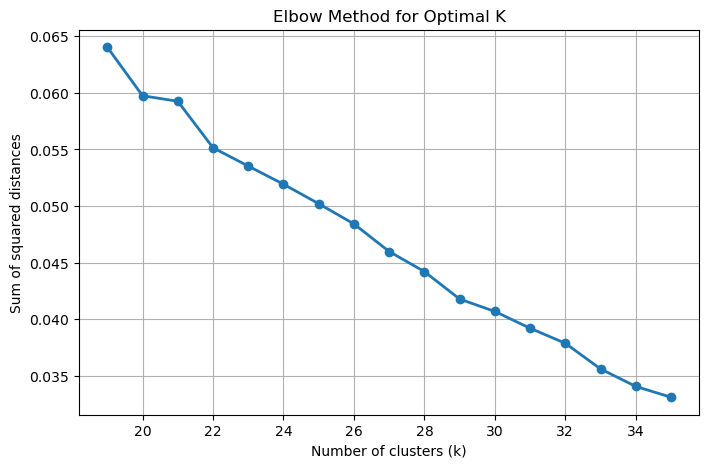

In [8]:
#Now, let's use the elbow method to determine the optimal number of clusters (k)
coords = f_cluster[['start_station_latitude', 'start_station_longitude']].values

k_values = range(19, 36)
inertias = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(coords)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, 'o-', linewidth=2)
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared distances')
plt.grid(True)
plt.show()


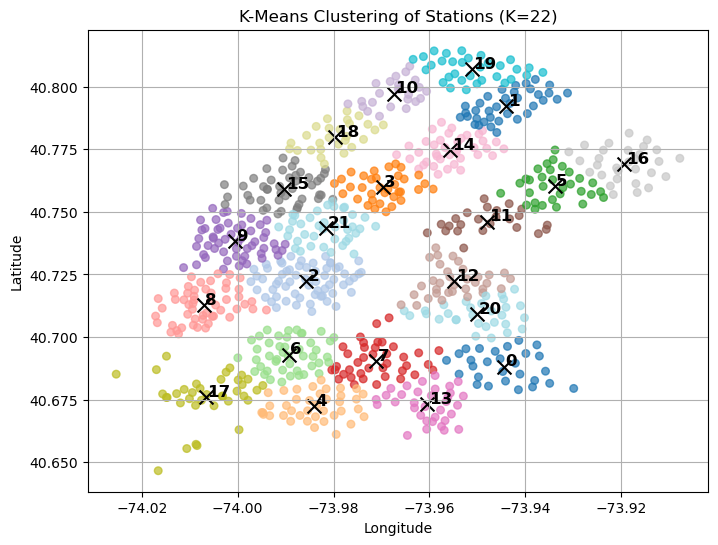

In [9]:
#We observe that k=22 should be a good choice for the number of clusters.

# Let's run the clustering and look at how the clusters look

# Extract coordinates
coords = f_cluster[['start_station_latitude', 'start_station_longitude']].values

# Run K-Means with 22 clusters
kmeans = KMeans(n_clusters=22, random_state=42)
f_cluster['cluster'] = kmeans.fit_predict(coords)

# Get cluster centers
centers = kmeans.cluster_centers_

# Plot data points colored by cluster
plt.figure(figsize=(8, 6))
plt.scatter(
    f_cluster['start_station_longitude'],
    f_cluster['start_station_latitude'],
    c=f_cluster['cluster'], cmap='tab20', s=30, alpha=0.7
)

# Plot cluster centers
plt.scatter(
    centers[:, 1], centers[:, 0],
    c='black', s=100, marker='x'
)

# Add numeric labels at each cluster center
for i, (lat, lon) in enumerate(centers):
    plt.text(
        lon + 0.0003, lat + 0.0003,   # small offset
        str(i), 
        fontsize=12, fontweight='bold', color='black'
    )

plt.title('K-Means Clustering of Stations (K=22)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

In [10]:
# We want to only look at the clusters that make up the island of Manhattan
# We remove the other clusters from both f_cluster and f

clusters_to_keep = [2,8,9,15,21]

# Normalize dtypes on keys before building merge
f = f.copy()
f['start_station_id'] = f['start_station_id'].astype(str)
f['end_station_id']   = f['end_station_id'].astype(str)

f_cluster = f_cluster.copy()
f_cluster['start_station_id'] = f_cluster['start_station_id'].astype(str)

stations_to_keep = f_cluster.loc[
    f_cluster['cluster'].isin(clusters_to_keep),
    'start_station_id'
].unique()

f = f[
    f['start_station_id'].isin(stations_to_keep) |
    f['end_station_id'].isin(stations_to_keep)
].copy()


2) You are expected to build a prediction model that, at the end of a day, allows to
predict what the demand for a cluster of stations will be over the next 24 hours – i.e.
not the total demand for the next day, but how the time-series of the demand will look
like for the next day (e.g., given demand data until midnight of day 1, predict the
number of pickups for all 1h intervals (12-1am, 1-2am, 6-7am, 7-8am, …, 11-12pm)
in day 2). You should predict both the arrivals (i.e., bicycle dropoffs) and the
departures (pickups). You should use a time aggregation of one hour or less. You
can choose to use two different models or a single one to predict both. It is up to you
to determine the most effective way to formulate this problem as a machine learning
problem. You should not shuffle the data. You should instead use the data from
January to October (included) to train your model, and the data from November and
December as a test set. You can use any model you want

In [11]:
f = f.merge(
    f_cluster[['start_station_id', 'cluster']]
      .rename(columns={'cluster': 'start_cluster'}),
    on='start_station_id',
    how='left'
)

f = f.merge(
    f_cluster[['start_station_id', 'cluster']]
      .rename(columns={'start_station_id': 'end_station_id', 'cluster': 'end_cluster'}),
    on='end_station_id',
    how='left'
)

for col in ['start_cluster', 'end_cluster']:
    f[col] = pd.to_numeric(f[col], errors='coerce').astype('Int64')

In [12]:
full_idx = pd.date_range(f['starttime'].min().floor('H'),
                         f['starttime'].max().ceil('H'),
                         freq='H')


def hourly_series_from_trips(df, time_col, cluster_col, cluster_id):
    """Return a single hourly Series (DatetimeIndex, freq='h') for one cluster."""
    s = (df.loc[df[cluster_col] == cluster_id, time_col]
           .dt.floor('H')
           .value_counts()
           .sort_index())
    s.index.name = 'timestamp'
    s = s.reindex(full_idx, fill_value=0).astype(int) # keep rows where there are now pickups/dropoffs
    s.name = f'{cluster_col}_{cluster_id}'
    return s

pickup_series  = {c: hourly_series_from_trips(f, 'starttime', 'start_cluster', c)
                  for c in clusters_to_keep}
dropoff_series = {c: hourly_series_from_trips(f, 'stoptime',  'end_cluster',   c)
                  for c in clusters_to_keep}


/var/folders/5w/sdj24sln3fvfc9dpydspvk380000gn/T/ipykernel_12280/4007237222.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_idx = pd.date_range(f['starttime'].min().floor('H'),
/var/folders/5w/sdj24sln3fvfc9dpydspvk380000gn/T/ipykernel_12280/4007237222.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  f['starttime'].max().ceil('H'),
/var/folders/5w/sdj24sln3fvfc9dpydspvk380000gn/T/ipykernel_12280/4007237222.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .dt.floor('H')
/var/folders/5w/sdj24sln3fvfc9dpydspvk380000gn/T/ipykernel_12280/4007237222.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .dt.floor('H')
/var/folders/5w/sdj24sln3fvfc9dpydspvk380000gn/T/ipykernel_12280/4007237222.py:9: FutureWarning: 'H' is deprecated and will be removed in a future versi

In [13]:
# PICKUPS
pick = (f.loc[f['start_cluster'].isin(clusters_to_keep), ['starttime','start_cluster']]
          .assign(timestamp=lambda x: x['starttime'].dt.floor('H'))
          .value_counts(['timestamp','start_cluster'])
          .rename('count')
          .reset_index())

# Build all (timestamp, cluster) combos, then left-join and fill 0
full_pairs = (
    pd.MultiIndex.from_product(
        [full_idx, sorted(clusters_to_keep)],
        names=['timestamp','start_cluster']
    ).to_frame(index=False)
)

pickup_all = (
    full_pairs.merge(pick, on=['timestamp','start_cluster'], how='left')
              .fillna({'count': 0})
              .astype({'count':'int64'})
              .set_index(['timestamp','start_cluster'])
              .sort_index()
)

# DROPOFFS
drop = (f.loc[f['end_cluster'].isin(clusters_to_keep), ['stoptime','end_cluster']]
          .assign(timestamp=lambda x: x['stoptime'].dt.floor('H'))
          .value_counts(['timestamp','end_cluster'])
          .rename('count')
          .reset_index())

full_pairs_d = (
    pd.MultiIndex.from_product(
        [full_idx, sorted(clusters_to_keep)],
        names=['timestamp','end_cluster']
    ).to_frame(index=False)
)

dropoff_all = (
    full_pairs_d.merge(drop, on=['timestamp','end_cluster'], how='left')
                .fillna({'count': 0})
                .astype({'count':'int64'})
                .set_index(['timestamp','end_cluster'])
                .sort_index()
)


/var/folders/5w/sdj24sln3fvfc9dpydspvk380000gn/T/ipykernel_12280/1095759283.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .assign(timestamp=lambda x: x['starttime'].dt.floor('H'))
/var/folders/5w/sdj24sln3fvfc9dpydspvk380000gn/T/ipykernel_12280/1095759283.py:26: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .assign(timestamp=lambda x: x['stoptime'].dt.floor('H'))


In [14]:
pickup_all = pickup_all.copy()  # optional, to avoid modifying in-place

# Extract hour of day and weekday
pickup_all['hour'] = pickup_all.index.get_level_values('timestamp').hour
pickup_all['weekday'] = pickup_all.index.get_level_values('timestamp').weekday

In [15]:
dropoff_all = dropoff_all.copy()

dropoff_all['hour'] = dropoff_all.index.get_level_values('timestamp').hour
dropoff_all['weekday'] = dropoff_all.index.get_level_values('timestamp').weekday


In [16]:
# Create dummy variables for weekday
weekday_dummies_p = pd.get_dummies(pickup_all['weekday'], prefix='weekday')
weekday_dummies_d = pd.get_dummies(dropoff_all['weekday'], prefix='weekday')

# Join back to the original dataframe
pickup_all = pickup_all.join(weekday_dummies_p)
dropoff_all = dropoff_all.join(weekday_dummies_d)

In [17]:
# Change from True/False to 1/0
weekday_cols_p = [col for col in pickup_all.columns if col.startswith('weekday_')]
pickup_all[weekday_cols_p] = pickup_all[weekday_cols_p].astype(int)
weekday_cols_d = [col for col in dropoff_all.columns if col.startswith('weekday_')]
dropoff_all[weekday_cols_d] = dropoff_all[weekday_cols_d].astype(int)


In [18]:
# Change the name of dummy columns to actual days
weekday_map = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}

# Identify weekday dummy columns
weekday_cols_p = [col for col in pickup_all.columns if col.startswith('weekday_')]
weekday_cols_d = [col for col in dropoff_all.columns if col.startswith('weekday_')]

# Build a renaming dict
rename_dict_p = {f'weekday_{i}': name for i, name in weekday_map.items() if f'weekday_{i}' in weekday_cols_p}
rename_dict_d = {f'weekday_{i}': name for i, name in weekday_map.items() if f'weekday_{i}' in weekday_cols_d}

# Rename the columns
pickup_all = pickup_all.rename(columns=rename_dict_p)
dropoff_all = dropoff_all.rename(columns=rename_dict_d)

In [19]:
# Drop 'weekday' column from both dataframes
pickup_all = pickup_all.drop(columns=['weekday'])
dropoff_all = dropoff_all.drop(columns=['weekday'])

In [20]:
def buildLaggedFeatures(s,columns, lag=2,dropna=True):
    '''
    From http://stackoverflow.com/questions/20410312/how-to-create-a-lagged-data-structure-using-pandas-dataframe
    Builds a new DataFrame to facilitate regressing over all possible lagged features
    '''
    if type(s) is pd.DataFrame:
        new_dict={}
        for c in s.columns:
            new_dict[c]=s[c]
        for col_name in columns:
            new_dict[col_name]=s[col_name]
            # create lagged Series
            for l in range(1,lag+1):
                new_dict['%s_lag%d' %(col_name,l)]=s[col_name].shift(l)
        res=pd.DataFrame(new_dict,index=s.index)

    elif type(s) is pd.Series:
        the_range=range(lag+1)
        res=pd.concat([s.shift(i) for i in the_range],axis=1)
        res.columns=['lag_%d' %i for i in the_range]
    else:
        print('Only works for DataFrame or Series')
        return None
    if dropna:
        return res.dropna()
    else:
        return res


In [21]:
pickup_lagged = buildLaggedFeatures(pickup_all, ['count'], lag=168, dropna=True)
dropoff_lagged = buildLaggedFeatures(dropoff_all, ['count'], lag=168, dropna=True)

In [22]:
def my_plot(regr, x, y, size=0.1):

    # The coefficients
    print('Coefficients: \n', regr.coef_)
    # The mean absolute error    
    print("Mean Absolute error (MAE): %.2f"% np.mean(abs(regr.predict(x) - y)))
    # The mean squared error
    print("Root Mean squared error: %.2f"
          % np.sqrt(np.mean((regr.predict(x) - y) ** 2)))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % regr.score(x, y))
          
    # Plot outputs
    plt.scatter(y, regr.predict(x), color='blue',linewidth=3)
    plt.plot([0, 5500], [0, 5500], color="red")
    plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
    plt.xlabel("observed")
    plt.ylabel("predicted")
    
    plt.show()

In [23]:
# Split into train and test sets
cutoff = pd.Timestamp('2018-10-31 23:59:59')
pickup_train = pickup_lagged[pickup_lagged.index.get_level_values('timestamp') <= cutoff]
pickup_test  = pickup_lagged[pickup_lagged.index.get_level_values('timestamp') >  cutoff]
dropoff_train = dropoff_lagged[dropoff_lagged.index.get_level_values('timestamp') <= cutoff]
dropoff_test  = dropoff_lagged[dropoff_lagged.index.get_level_values('timestamp') >  cutoff]

In [24]:
pickup_train.head()

count  hour  Monday  Tuesday  Wednesday  \
timestamp           start_cluster                                            
2018-01-02 09:00:00 15               190     9       0        1          0   
                    21               212     9       0        1          0   
2018-01-02 10:00:00 2                 92    10       0        1          0   
                    8                 40    10       0        1          0   
                    9                100    10       0        1          0   

                                   Thursday  Friday  Saturday  Sunday  \
timestamp           start_cluster                                       
2018-01-02 09:00:00 15                    0       0         0       0   
                    21                    0       0         0       0   
2018-01-02 10:00:00 2                     0       0         0       0   
                    8                     0       0         0       0   
                    9                     0       0         0       0   

                                   count_lag1  ...  count_lag159  \
timestamp           start_cluster              ...                 
2018-01-02 09:00:00 15                  191.0  ...          16.0   
                    21                  190.0  ...          17.0   
2018-01-02 10:00:00 2                   212.0  ...           5.0   
                    8                    92.0  ...          14.0   
                    9                    40.0  ...           7.0   

                                   count_lag160  count_lag161  count_lag162  \
timestamp           start_cluster                                             
2018-01-02 09:00:00 15                     13.0          31.0           7.0   
                    21                     16.0          13.0          31.0   
2018-01-02 10:00:00 2                      17.0          16.0          13.0   
                    8                       5.0          17.0          16.0   
                    9                      14.0           5.0          17.0   

                                   count_lag163  count_lag164  count_lag165  \
timestamp           start_cluster                                             
2018-01-02 09:00:00 15                     32.0          11.0          13.0   
                    21                      7.0          32.0          11.0   
2018-01-02 10:00:00 2                      31.0           7.0          32.0   
                    8                      13.0          31.0           7.0   
                    9                      16.0          13.0          31.0   

                                   count_lag166  count_lag167  count_lag168  
timestamp           start_cluster                                            
2018-01-02 09:00:00 15                     20.0          11.0          16.0  
                    21                     13.0          20.0          11.0  
2018-01-02 10:00:00 2                      11.0          13.0          20.0  
                    8                      32.0          11.0          13.0  
                    9                       7.0          32.0          11.0  

[5 rows x 177 columns]

In [25]:
# from sklearn.linear_model import Lasso
# from sklearn.metrics import mean_squared_error

# # Fit a Lasso regression model for pickups

# base_features = ['hour', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# lag_features = [f'count_lag{i}' for i in range(1, 169)]

# # Full feature set
# feature_cols = base_features + lag_features
# target_col = 'count'





In [26]:
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LassoCV
# from sklearn.metrics import mean_squared_error
# import pandas as pd
# import numpy as np

# # Define features and target
# base_features = ['hour', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# lag_features = [f'count_lag{i}' for i in range(1, 169)]
# feature_cols = base_features + lag_features
# target_col = 'count'

# # Get clusters
# clusters = pickup_train.index.get_level_values('start_cluster').unique()

# # Initialize storage for metrics and predictions
# pipeline_models = {}       # store fitted pipelines
# predictions_test = []      # store test predictions

# for cluster in clusters:
#     # Slice data for this cluster
#     X_train = pickup_train.xs(cluster, level='start_cluster')[feature_cols]
#     y_train = pickup_train.xs(cluster, level='start_cluster')[target_col]

#     X_test = pickup_test.xs(cluster, level='start_cluster')[feature_cols]
#     y_test = pickup_test.xs(cluster, level='start_cluster')[target_col]

#     # Build pipeline: scaler + LassoCV
#     pipeline = Pipeline([
#         ('scaler', StandardScaler()),
#         ('lasso', LassoCV(cv=5, random_state=42, max_iter=10000))
#     ])

#     # Fit model on train data
#     pipeline.fit(X_train, y_train)

#     # Store fitted pipeline for later train predictions
#     pipeline_models[cluster] = pipeline

#     # Predict on test set
#     y_pred = pipeline.predict(X_test)
#     pred_df = pd.DataFrame({
#         'timestamp': X_test.index,
#         'start_cluster': cluster,
#         'y_true': y_test.values,
#         'y_pred': y_pred
#     })
#     predictions_test.append(pred_df)

# # Combine all cluster predictions into one DataFrame
# predictions_test_df = pd.concat(predictions_test).set_index(['timestamp','start_cluster']).sort_index()

# metrics_df = pd.DataFrame(metrics_list).set_index('cluster')

# # Results
# print(metrics_df)
# print(predictions_test_df.head())


In [27]:
# # Plot predictions vs actuals for the first two weeks of the test set for all clusters

# # Define time range: first two weeks of the test set
# start_date = pickup_test.index.get_level_values('timestamp').min()
# end_date = start_date + pd.Timedelta(days=14)

# # Filter predictions to this time range
# predictions_plot = predictions_test_df.loc[
#     (predictions_test_df.index.get_level_values('timestamp') >= start_date) &
#     (predictions_test_df.index.get_level_values('timestamp') < end_date)
# ]

# # Plot all clusters in subplots
# num_clusters = len(clusters)
# fig, axes = plt.subplots(num_clusters, 1, figsize=(15, 4*num_clusters), sharex=True)

# for i, cluster in enumerate(clusters):
#     # Slice data for this cluster
#     df_plot = predictions_plot.xs(cluster, level='start_cluster')
    
#     axes[i].plot(df_plot.index, df_plot['y_true'], label='Actual', color='blue')
#     axes[i].plot(df_plot.index, df_plot['y_pred'], label='Predicted', color='red', alpha=0.7)
#     axes[i].set_title(f'Pickups - Cluster {cluster} (First 2 Weeks of Test)')
#     axes[i].set_ylabel('Count')
#     axes[i].legend()
#     axes[i].grid(True)

# plt.xlabel('Timestamp')
# plt.tight_layout()
# plt.show()

In [28]:
# from sklearn.metrics import r2_score, mean_absolute_error

# # Helper function for MAPE
# def mean_absolute_percentage_error(y_true, y_pred):
#     y_true, y_pred = np.array(y_true), np.array(y_pred)
#     mask = y_true != 0
#     return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# # Initialize list to store metrics
# metrics_list = []

# for cluster in clusters:
#     # Slice cluster data
#     df_train = pickup_train.xs(cluster, level='start_cluster')
#     df_test = pickup_test.xs(cluster, level='start_cluster')
    
#     # Get fitted pipeline
#     pipeline = pipeline_models[cluster]
    
#     # Predict
#     y_train_true = df_train['count']
#     y_train_pred = pipeline.predict(df_train[feature_cols])
    
#     y_test_true = df_test['count']
#     y_test_pred = pipeline.predict(df_test[feature_cols])
    
#     # Compute metrics
#     metrics_list.append({
#         'cluster': cluster,
#         'r2_train': r2_score(y_train_true, y_train_pred),
#         'r2_test': r2_score(y_test_true, y_test_pred),
#         'mae_train': mean_absolute_error(y_train_true, y_train_pred),
#         'mae_test': mean_absolute_error(y_test_true, y_test_pred),
#         'mape_train': mean_absolute_percentage_error(y_train_true, y_train_pred),
#         'mape_test': mean_absolute_percentage_error(y_test_true, y_test_pred)
#     })

# # Convert to DataFrame
# metrics_df = pd.DataFrame(metrics_list).set_index('cluster')

# # Show table
# metrics_df


In [29]:
pickup_train.head()

count  hour  Monday  Tuesday  Wednesday  \
timestamp           start_cluster                                            
2018-01-02 09:00:00 15               190     9       0        1          0   
                    21               212     9       0        1          0   
2018-01-02 10:00:00 2                 92    10       0        1          0   
                    8                 40    10       0        1          0   
                    9                100    10       0        1          0   

                                   Thursday  Friday  Saturday  Sunday  \
timestamp           start_cluster                                       
2018-01-02 09:00:00 15                    0       0         0       0   
                    21                    0       0         0       0   
2018-01-02 10:00:00 2                     0       0         0       0   
                    8                     0       0         0       0   
                    9                     0       0         0       0   

                                   count_lag1  ...  count_lag159  \
timestamp           start_cluster              ...                 
2018-01-02 09:00:00 15                  191.0  ...          16.0   
                    21                  190.0  ...          17.0   
2018-01-02 10:00:00 2                   212.0  ...           5.0   
                    8                    92.0  ...          14.0   
                    9                    40.0  ...           7.0   

                                   count_lag160  count_lag161  count_lag162  \
timestamp           start_cluster                                             
2018-01-02 09:00:00 15                     13.0          31.0           7.0   
                    21                     16.0          13.0          31.0   
2018-01-02 10:00:00 2                      17.0          16.0          13.0   
                    8                       5.0          17.0          16.0   
                    9                      14.0           5.0          17.0   

                                   count_lag163  count_lag164  count_lag165  \
timestamp           start_cluster                                             
2018-01-02 09:00:00 15                     32.0          11.0          13.0   
                    21                      7.0          32.0          11.0   
2018-01-02 10:00:00 2                      31.0           7.0          32.0   
                    8                      13.0          31.0           7.0   
                    9                      16.0          13.0          31.0   

                                   count_lag166  count_lag167  count_lag168  
timestamp           start_cluster                                            
2018-01-02 09:00:00 15                     20.0          11.0          16.0  
                    21                     13.0          20.0          11.0  
2018-01-02 10:00:00 2                      11.0          13.0          20.0  
                    8                      32.0          11.0          13.0  
                    9                       7.0          32.0          11.0  

[5 rows x 177 columns]

In [30]:
def my_plot(regr, x, y, size=0.1):

    # The coefficients
    print('Coefficients: \n', regr.coef_)
    # The mean absolute error    
    print("Mean Absolute error (MAE): %.2f"% np.mean(abs(regr.predict(x) - y)))
    # The mean squared error
    print("Root Mean squared error: %.2f"
          % np.sqrt(np.mean((regr.predict(x) - y) ** 2)))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % regr.score(x, y))
          
    # Plot outputs
    plt.scatter(y, regr.predict(x), color='blue',linewidth=3)
    plt.plot([0, 1400], [0, 1400], color="red")
    plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
    plt.xlabel("observed")
    plt.ylabel("predicted")
    
    plt.show()

In [31]:
# # Let's fit a Lasso regression model on pickups to predict bike_count 
# from sklearn.linear_model import Lasso


# lasso_pickup = Lasso(alpha=0.1)
# lasso_pickup.fit(
#     pickup_train.drop(columns=["count"]),
#     pickup_train["count"]
# )
# # Now let's evaluate the model on the test set
# my_plot(
#     lasso_pickup,
#     pickup_test.drop(columns=["count"]),
#     pickup_test["count"]
# )

In [32]:
# # Let's do this for each cluster separately

# clusters = pickup_train.index.get_level_values("start_cluster").unique()

# lasso_models = {}   # store models if you want them later

# for cluster in clusters:
#     # Extract this cluster’s training data
#     X_train = pickup_train.xs(cluster, level="start_cluster").drop(columns=["count"])
#     y_train = pickup_train.xs(cluster, level="start_cluster")["count"]

#     # Extract this cluster’s test data
#     X_test  = pickup_test.xs(cluster, level="start_cluster").drop(columns=["count"])
#     y_test  = pickup_test.xs(cluster, level="start_cluster")["count"]

#     # Fit Lasso model
#     #model = Lasso(alpha=0.1)
#     lasso_pickup.fit(X_train, y_train)

#     # Store model (optional)
#     lasso_models[cluster] = lasso_pickup

#     # Plot results for this cluster
#     print(f"\n=== Cluster {cluster} ===")
#     my_plot(
#         lasso_pickup,
#         X_test,
#         y_test
#     )

In [33]:
def plotprediction(series, pred_series, metrics, labels=["original", "predicted"], x_axis=None, plot_intervals=False, scale=1.96, plot_anomalies=False, title="prediction"):

    plt.figure(figsize=(15,5))
    plt.title(title)
    if x_axis is None:
        x_axis=series.index
    
    plt.plot(x_axis, pred_series, "g", label=labels[1])
    plt.plot(x_axis, series, label=labels[0])
    plt.legend(loc="upper right")
    plt.grid(True)
    
    ax = plt.gca()
    ax.text(0.01, 0.95, "\n".join(metrics),
            transform=ax.transAxes, ha="left", va="top",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.75))
    plt.tight_layout()
    # Plot confidence intervals for smoothed values
    plt.show()

In [34]:
# from sklearn.metrics import mean_absolute_error, r2_score
# import numpy as np
# import pandas as pd

# # MAPE helper
# def mape(y_true, y_pred):
#     y_true, y_pred = np.array(y_true), np.array(y_pred)
#     mask = y_true != 0
#     return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100


# # ------------------------------------------------------
# # 1) Time window for first two weeks of November test set
# # ------------------------------------------------------
# start_date = pd.Timestamp("2018-11-01 00:00:00")
# end_date   = start_date + pd.Timedelta(days=14)


# # ------------------------------------------------------
# # 2) Loop through clusters and plot
# # ------------------------------------------------------
# for cluster in clusters:

#     # Entire test set for this cluster
#     X_test_full = pickup_test.xs(cluster, level="start_cluster").drop(columns=["count"])
#     y_test_full = pickup_test.xs(cluster, level="start_cluster")["count"]

#     # Predict on the entire test set
#     model = lasso_models[cluster]
#     y_pred_full = model.predict(X_test_full)

#     # ---------------------------
#     # Full test-set metrics
#     # ---------------------------
#     r2  = r2_score(y_test_full, y_pred_full)
#     mae = mean_absolute_error(y_test_full, y_pred_full)
#     mape_val = mape(y_test_full, y_pred_full)

#     metrics = [
#         f"R² (full test):   {r2:.3f}",
#         f"MAE (full test):  {mae:.3f}",
#         f"MAPE (full test): {mape_val:.2f}%"
#     ]

#     # ---------------------------
#     # First 2 weeks subset for plotting
#     # ---------------------------
#     mask = (X_test_full.index >= start_date) & (X_test_full.index < end_date)
    
#     y_plot = y_test_full.loc[mask]
#     y_pred_plot = pd.Series(y_pred_full, index=y_test_full.index).loc[mask]

#     # ---------------------------
#     # Plot only the 2-week period
#     # ---------------------------
#     plotprediction(
#         series=y_plot,
#         pred_series=y_pred_plot,
#         metrics=metrics,                # <-- full test metrics
#         labels=["Actual", "Predicted"],
#         x_axis=y_plot.index,
#         title=f"Cluster {cluster} — Predictions vs Actual (First 2 Weeks of Nov)"
#     )


In [35]:
# # The same but for the train set



# # ------------------------------------------------------
# # 1) Time window: first two weeks of the TRAIN set
# # ------------------------------------------------------
# train_start_date = pickup_train.index.get_level_values("timestamp").min()
# train_end_date   = train_start_date + pd.Timedelta(days=14)


# # ------------------------------------------------------
# # 2) Loop through clusters — TRAIN reference plots
# # ------------------------------------------------------
# for cluster in clusters:

#     # Entire TRAIN set for this cluster
#     X_train_full = pickup_train.xs(cluster, level="start_cluster").drop(columns=["count"])
#     y_train_full = pickup_train.xs(cluster, level="start_cluster")["count"]

#     # Predict on entire TRAIN set
#     model = lasso_models[cluster]
#     y_pred_train_full = model.predict(X_train_full)

#     # ---------------------------
#     # Full train-set metrics
#     # ---------------------------
#     r2_train  = r2_score(y_train_full, y_pred_train_full)
#     mae_train = mean_absolute_error(y_train_full, y_pred_train_full)
#     mape_train = mape(y_train_full, y_pred_train_full)

#     metrics = [
#         f"R² (train full):   {r2_train:.3f}",
#         f"MAE (train full):  {mae_train:.3f}",
#         f"MAPE (train full): {mape_train:.2f}%"
#     ]

#     # ---------------------------
#     # First 2 weeks subset for plotting
#     # ---------------------------
#     mask = (X_train_full.index >= train_start_date) & (X_train_full.index < train_end_date)

#     y_plot = y_train_full.loc[mask]
#     y_pred_plot = pd.Series(y_pred_train_full, index=y_train_full.index).loc[mask]

#     # ---------------------------
#     # Plot only the 2-week period
#     # ---------------------------
#     plotprediction(
#         series=y_plot,
#         pred_series=y_pred_plot,
#         metrics=metrics,       # <-- full train metrics added
#         labels=["Actual", "Predicted"],
#         x_axis=y_plot.index,
#         title=f"Cluster {cluster} — TRAIN (First 2 Weeks)"
#     )


In [36]:
# # Now let's plot the total pickup for each hour througout the year for the chosen clusters
# # create an hour column
# f['hour'] = f['starttime'].dt.hour

# # --- Compute total pickups per hour ---
# hourly_counts = f.groupby('hour').size()

# # Ensure all 24 hours exist
# hourly_counts = hourly_counts.reindex(range(24), fill_value=0)

# # --- Plot ---
# plt.figure(figsize=(12,6))
# plt.bar(hourly_counts.index, hourly_counts.values)
# plt.xlabel("Hour of Day (0–23)")
# plt.ylabel("Total Pickups in Year")
# plt.title("Total Pickups per Hour Throughout the Year")
# plt.xticks(range(24))
# plt.grid(axis='y', linestyle='--', alpha=0.4)
# plt.tight_layout()
# plt.show()

In [37]:
# # --- Assumptions ---

# # Station id column:
# station_col = f['start_station_id']  # adjust if different

# # --- Build day & hour keys ---
# f['day']  = f['starttime'].dt.day    # midnight-normalized dates (YYYY-MM-DD as Timestamp)
# f['hour'] = f['starttime'].dt.hour            # 0..23

# # --- Group by cluster/day/hour and pivot to day x hour ---
# grp = f.groupby(['cluster', 'day', 'hour']).size()

# # Make sure all 24 hours exist in every pivot
# def pivot_cluster(g):
#     df = (g.unstack('hour', fill_value=0)
#             .reindex(columns=range(24), fill_value=0))
#     return df

# cluster_pivot = grp.groupby(level='cluster', group_keys=False).apply(pivot_cluster)

# # --- Ensure all days in your year appear, even if zeros (nice for modeling) ---
# date_min = f['day'].min()
# date_max = f['day'].max()
# all_days = pd.date_range(date_min, date_max, freq='D')

# def reindex_days(df):
#     return df.reindex(all_days, fill_value=0)

# #cluster_pivot = cluster_pivot.groupby(level='cluster', group_keys=True)\
# #                             .apply(reindex_days)

# # Now `cluster_pivot` has a MultiIndex row (cluster, day) and columns 0..23.
# # If you prefer separate tables per cluster:
# cluster_tables = {
#     c: cluster_pivot.xs(c, level='cluster').rename_axis('day')
#     for c in cluster_pivot.index.get_level_values('cluster').unique()
# }

# # change the number to see for each cluster
# cluster_tables[8]



In [38]:
# # Drop columns 
# f.drop(columns=['bikeid', 'gender', 'birth_year', 'start_station_latitude', 'start_station_longitude', 'end_station_latitude', 'end_station_longitude', 'usertype'], axis=1, inplace=True)

# # Add column to 'f' representing day of the week
# f['day_of_week'] = f['starttime'].dt.dayofweek

In [39]:
# # Make new dataframe with bike counts per hour

# f["starttime"] = pd.to_datetime(f["starttime"])

# f["hour_start"] = f["starttime"].dt.floor("H")

# hourly = (
#     f.groupby("hour_start")
#       .size()
#       .reset_index(name="bike_count")
# )

# hourly["hour_of_day"] = hourly["hour_start"].dt.hour
# hourly["weekday"] = hourly["hour_start"].dt.dayofweek

# hourly

In [40]:
# # create weekday dummy variables
# hourly_with_dummies = pd.get_dummies(
#     hourly,
#     columns=["weekday"],
#     prefix="wd",
#     dtype=int
# )

In [41]:
# hourly_with_dummies.head()

In [42]:
# weekday_names = {
#     0: "Monday",
#     1: "Tuesday",
#     2: "Wednesday",
#     3: "Thursday",
#     4: "Friday",
#     5: "Saturday",
#     6: "Sunday"
# }

# # build a rename dictionary for the dummy columns
# rename_dict = {f"weekday_{k}": v for k, v in weekday_names.items()}

# # apply renaming (works with your dummies, whatever their prefix)
# hourly_with_dummies = hourly_with_dummies.rename(columns=rename_dict)

In [43]:
# # Change names of the dummy columns to actual weekday names 
# weekday_names = {
#     0: "Monday",
#     1: "Tuesday",
#     2: "Wednesday",
#     3: "Thursday",
#     4: "Friday",
#     5: "Saturday",
#     6: "Sunday"
# }

# rename_dict = {f"wd_{k}": v for k, v in weekday_names.items()}

# hourly_with_dummies = hourly_with_dummies.rename(columns=rename_dict)

# hourly_with_dummies.head()

In [44]:
# # define cutoff
# cutoff = pd.Timestamp("2018-11-01")

# # train: start → end of October 2018
# X_train = hourly_with_dummies[hourly_with_dummies["hour_start"] < cutoff]

# # test: November 1st 2018 → end
# X_test = hourly_with_dummies[hourly_with_dummies["hour_start"] >= cutoff]

In [45]:
# # Let's build lagged features for bike_count with a lag of 168 hours (1 week)
# hourly_lagged = buildLaggedFeatures(hourly_with_dummies, columns=["bike_count"], lag=168, dropna=True)
# hourly_lagged.head()

In [47]:
#hourly_lagged.head()

In [ ]:
# # define cutoff
# cutoff = pd.Timestamp("2018-11-01")

# # train: start → end of October 2018
# X_train = hourly_lagged[hourly_lagged["hour_start"] < cutoff]

# # test: November 1st 2018 → end
# X_test = hourly_lagged[hourly_lagged["hour_start"] >= cutoff]

In [ ]:
# # Let's fit a Lasso regression model on X_train to predict bike_count 
# from sklearn.linear_model import Lasso
# lasso = Lasso(alpha=0.1)
# lasso.fit(
#     X_train.drop(columns=["hour_start", "bike_count"]),
#     X_train["bike_count"]
# )
# # Now let's evaluate the model on the test set
# my_plot(
#     lasso,
#     X_test.drop(columns=["hour_start", "bike_count"]),
#     X_test["bike_count"]
# )

In [ ]:
# # Plot predictions vs actuals, but only for first week of November for clarity
# plotprediction(
#     series=X_test["bike_count"].iloc[:24*7],
#     pred_series=pd.Series(
#         lasso.predict(
#             X_test.drop(columns=["hour_start", "bike_count"])
#         ),
#         index=X_test.index
#     ).iloc[:24*7],
#     metrics=[
#         f"MAE: {np.mean(abs(lasso.predict(X_test.drop(columns=['hour_start', 'bike_count'])) - X_test['bike_count'])):.2f}",
#         f"RMSE: {np.sqrt(np.mean((lasso.predict(X_test.drop(columns=['hour_start', 'bike_count'])) - X_test['bike_count']) ** 2)):.2f}",
#         f"Variance score: {lasso.score(X_test.drop(columns=['hour_start', 'bike_count']), X_test['bike_count']):.2f}"
#     ],
#     title="Lasso Regression Predictions vs Actuals (First Week of November 2018)"
# )


-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-


In [ ]:
!pip install lightgbm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.3 MB/s eta 0:00:00


In [48]:
# Gradient Boosting with LightGBM for the pickup data


import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, r2_score

# Dictionary to store models and predictions
lgb_models = {}
lgb_predictions_test = {}
lgb_predictions_train = {}
lgb_metrics = {}

clusters = sorted(pickup_train.index.get_level_values("start_cluster").unique())

feature_cols = [c for c in pickup_train.columns if c != "count"]

for cluster in clusters:
    print(f"Training LightGBM for cluster {cluster}...")
    
    # Extract cluster data
    train_df = pickup_train.xs(cluster, level="start_cluster")
    test_df  = pickup_test.xs(cluster, level="start_cluster")
    
    X_train = train_df[feature_cols]
    y_train = train_df["count"]
    
    X_test = test_df[feature_cols]
    y_test = test_df["count"]
    
    # LightGBM model
    model = lgb.LGBMRegressor(
        n_estimators=600,
        learning_rate=0.03,
        subsample=0.8,
        colsample_bytree=0.8,
        num_leaves=50,
        random_state=42
    )
    
    # Train
    model.fit(X_train, y_train)
    
    # Predictions
    pred_train = model.predict(X_train)
    pred_test  = model.predict(X_test)
    
    # Store everything
    lgb_models[cluster] = model
    lgb_predictions_train[cluster] = pred_train
    lgb_predictions_test[cluster]  = pred_test
    
    # Metrics
    lgb_metrics[cluster] = {
        "r2_train": r2_score(y_train, pred_train),
        "r2_test":  r2_score(y_test,  pred_test),
        "mae_train": mean_absolute_error(y_train, pred_train),
        "mae_test":  mean_absolute_error(y_test,  pred_test),
        "mape_train": (np.abs((y_train - pred_train) / y_train.replace(0, np.nan))).mean(),
        "mape_test":  (np.abs((y_test - pred_test) / y_test.replace(0, np.nan))).mean(),
    }


Training LightGBM for cluster 2...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42878
[LightGBM] [Info] Number of data points in the train set: 7262, number of used features: 176
[LightGBM] [Info] Start training from score 260.813963
Training LightGBM for cluster 8...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42878
[LightGBM] [Info] Number of data points in the train set: 7262, number of used features: 176
[LightGBM] [Info] Start training from score 203.137841
Training LightGBM for cluster 9...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42878
[LightGB

In [ ]:
# Summary 

metrics_df = pd.DataFrame(lgb_metrics).T
metrics_df


,r2_train,r2_test,mae_train,mae_test,mape_train,mape_test
2,0.997062,0.961508,8.317437,22.246931,0.120184,0.232915
8,0.998827,0.955970,5.659936,17.732288,0.149018,0.244545
9,0.998850,0.981525,7.079439,19.652618,0.101150,0.229483
15,0.998395,0.982246,6.303182,15.142980,0.111953,0.215478
21,0.999070,0.986574,5.175082,14.668238,0.113741,0.186917


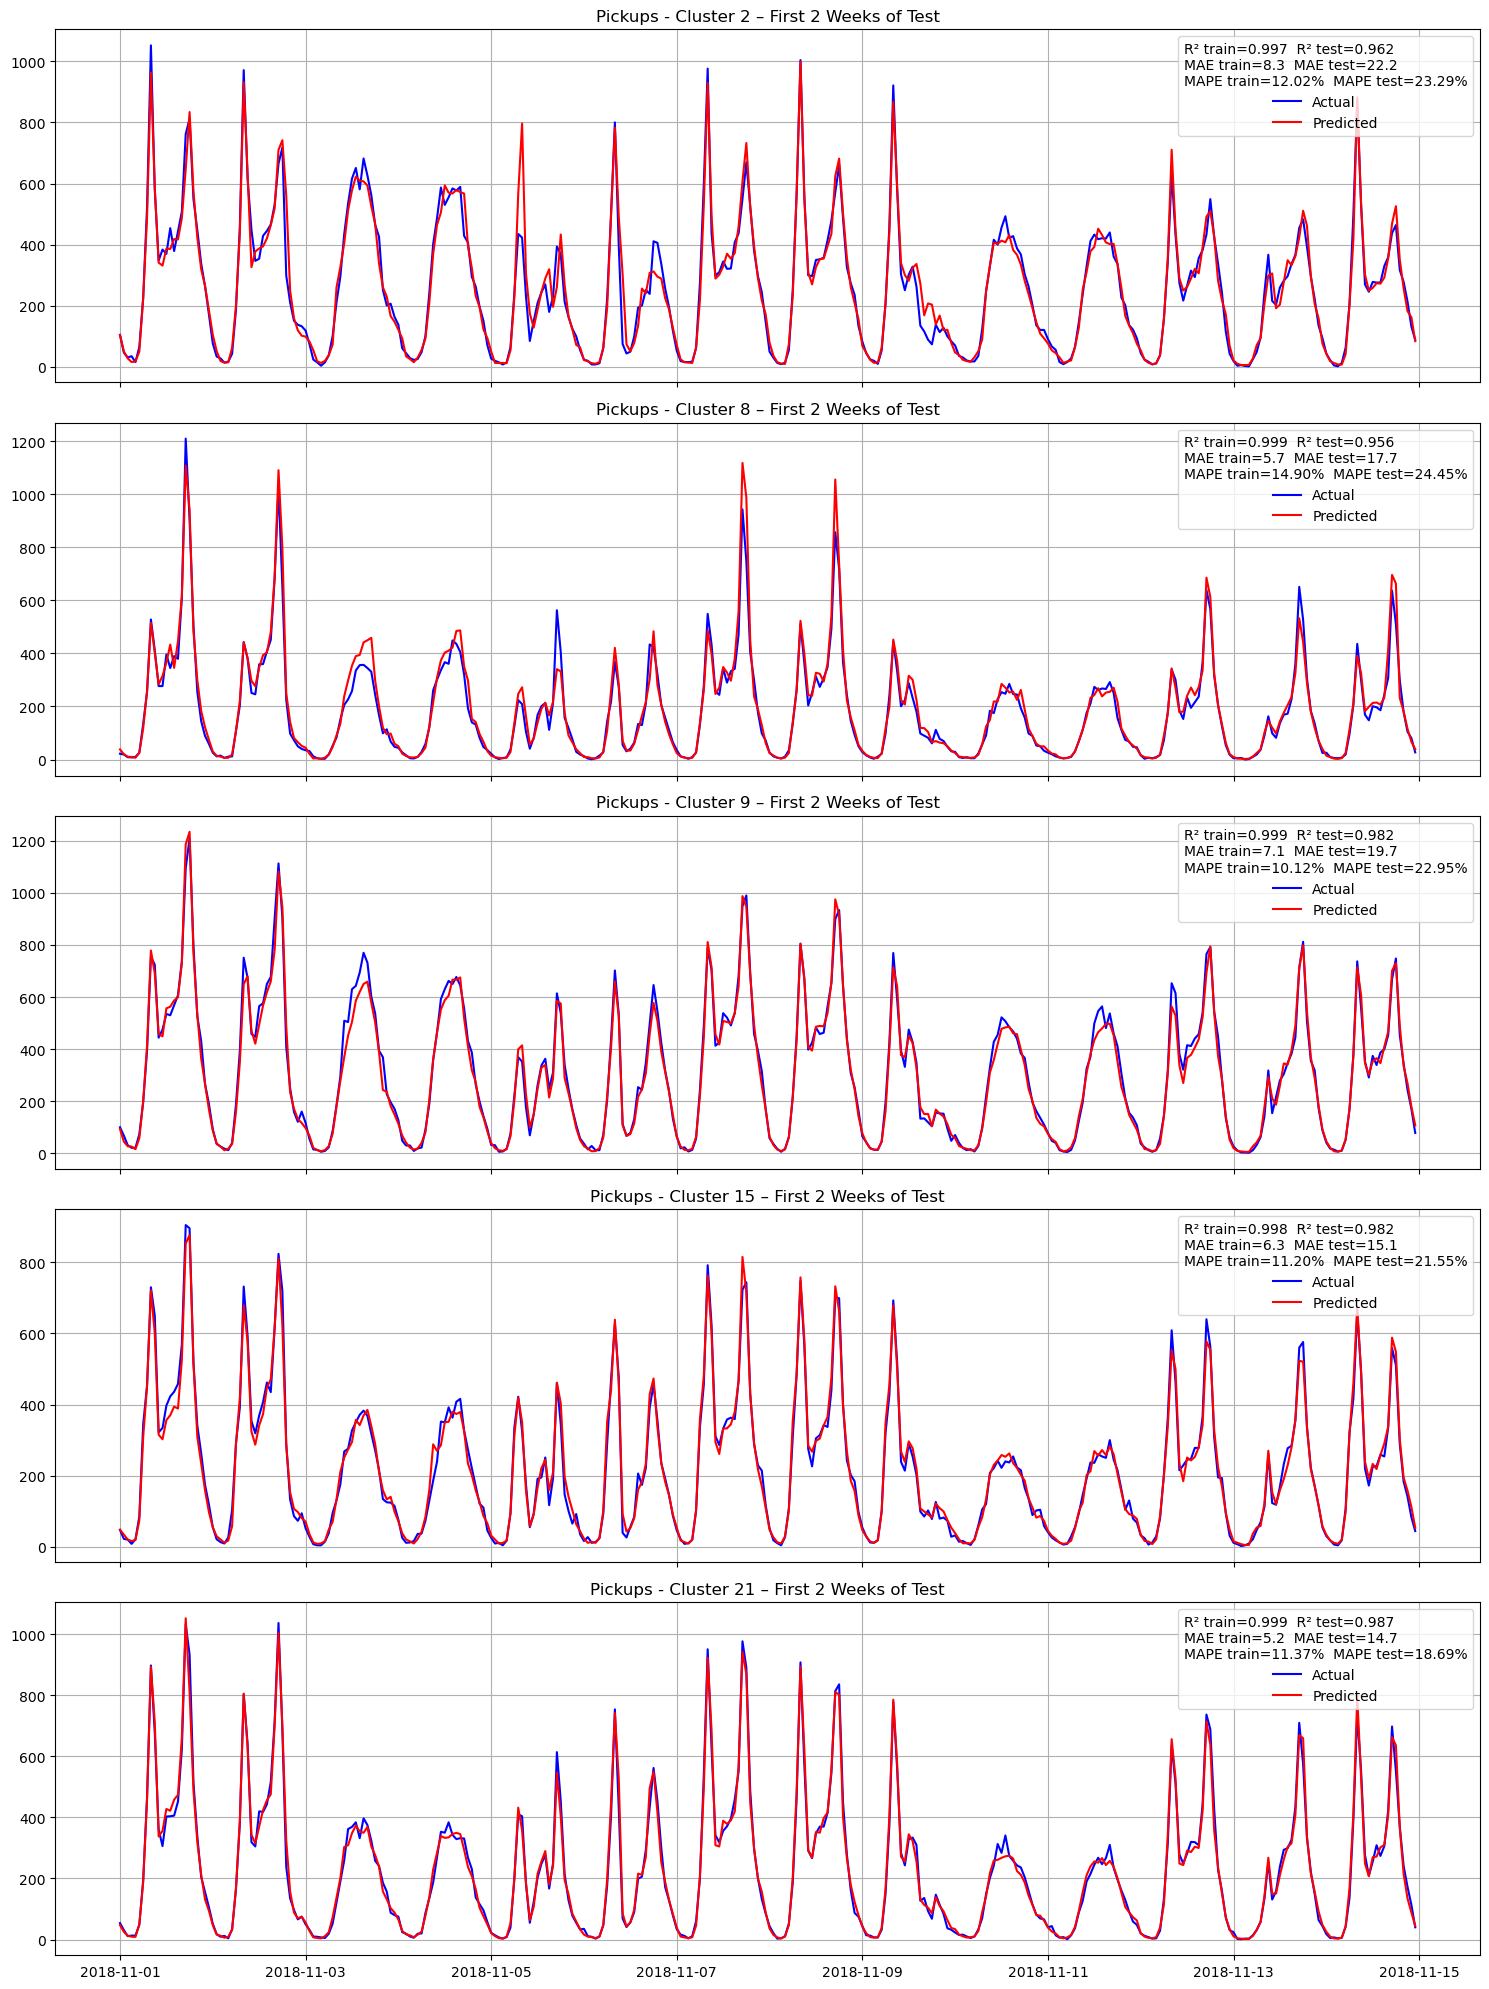

In [50]:
# First 2-week window
start_date = pickup_test.index.get_level_values('timestamp').min()
end_date = start_date + pd.Timedelta(days=14)

fig, axes = plt.subplots(len(clusters), 1, figsize=(15, 4*len(clusters)), sharex=True)

for i, cluster in enumerate(clusters):
    
    df_test = pickup_test.xs(cluster, level='start_cluster')
    df_two_weeks = df_test.loc[(df_test.index >= start_date) & (df_test.index < end_date)]
    
    pred_series = pd.Series(
        lgb_predictions_test[cluster],
        index=df_test.index
    ).loc[df_two_weeks.index]
    
    axes[i].plot(df_two_weeks.index, df_two_weeks['count'], label="Actual", color="blue")
    axes[i].plot(df_two_weeks.index, pred_series, label="Predicted", color="red")
    
    # Add metrics in legend
    m = lgb_metrics[cluster]
    axes[i].legend(title=(
        f"R² train={m['r2_train']:.3f}  R² test={m['r2_test']:.3f}\n"
        f"MAE train={m['mae_train']:.1f}  MAE test={m['mae_test']:.1f}\n"
        f"MAPE train={m['mape_train']:.2%}  MAPE test={m['mape_test']:.2%}"
    ))
    
    axes[i].set_title(f"Pickups - Cluster {cluster} – First 2 Weeks of Test")
    axes[i].grid(True)

plt.tight_layout()
plt.show()


In [51]:
# Now for the dropoffs

# Dictionary to store models and predictions
lgb_models_drop = {}
lgb_predictions_test_drop = {}
lgb_predictions_train_drop = {}
lgb_metrics_drop = {}

clusters = sorted(dropoff_train.index.get_level_values("end_cluster").unique())

feature_cols = [c for c in dropoff_train.columns if c != "count"]

for cluster in clusters:
    print(f"Training LightGBM for cluster {cluster}...")
    
    # Extract cluster data
    train_df = dropoff_train.xs(cluster, level="end_cluster")
    test_df  = dropoff_test.xs(cluster, level="end_cluster")
    
    X_train = train_df[feature_cols]
    y_train = train_df["count"]
    
    X_test = test_df[feature_cols]
    y_test = test_df["count"]
    
    # LightGBM model
    model = lgb.LGBMRegressor(
        n_estimators=600,
        learning_rate=0.03,
        subsample=0.8,
        colsample_bytree=0.8,
        num_leaves=50,
        random_state=42
    )
    
    # Train
    model.fit(X_train, y_train)
    
    # Predictions
    pred_train = model.predict(X_train)
    pred_test  = model.predict(X_test)
    
    # Store everything
    lgb_models_drop[cluster] = model
    lgb_predictions_train_drop[cluster] = pred_train
    lgb_predictions_test_drop[cluster]  = pred_test
    
    # Metrics
    lgb_metrics_drop[cluster] = {
        "r2_train": r2_score(y_train, pred_train),
        "r2_test":  r2_score(y_test,  pred_test),
        "mae_train": mean_absolute_error(y_train, pred_train),
        "mae_test":  mean_absolute_error(y_test,  pred_test),
        "mape_train": (np.abs((y_train - pred_train) / y_train.replace(0, np.nan))).mean(),
        "mape_test":  (np.abs((y_test - pred_test) / y_test.replace(0, np.nan))).mean(),
    }


Training LightGBM for cluster 2...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42878
[LightGBM] [Info] Number of data points in the train set: 7262, number of used features: 176
[LightGBM] [Info] Start training from score 262.815340
Training LightGBM for cluster 8...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42878
[LightGBM] [Info] Number of data points in the train set: 7262, number of used features: 176
[LightGBM] [Info] Start training from score 206.888736
Training LightGBM for cluster 9...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42878
[LightGB

In [ ]:
# Summary 

metrics_df_drop = pd.DataFrame(lgb_metrics).T
metrics_df_drop


,r2_train,r2_test,mae_train,mae_test,mape_train,mape_test
2,0.997062,0.961508,8.317437,22.246931,0.120184,0.232915
8,0.998827,0.955970,5.659936,17.732288,0.149018,0.244545
9,0.998850,0.981525,7.079439,19.652618,0.101150,0.229483
15,0.998395,0.982246,6.303182,15.142980,0.111953,0.215478
21,0.999070,0.986574,5.175082,14.668238,0.113741,0.186917


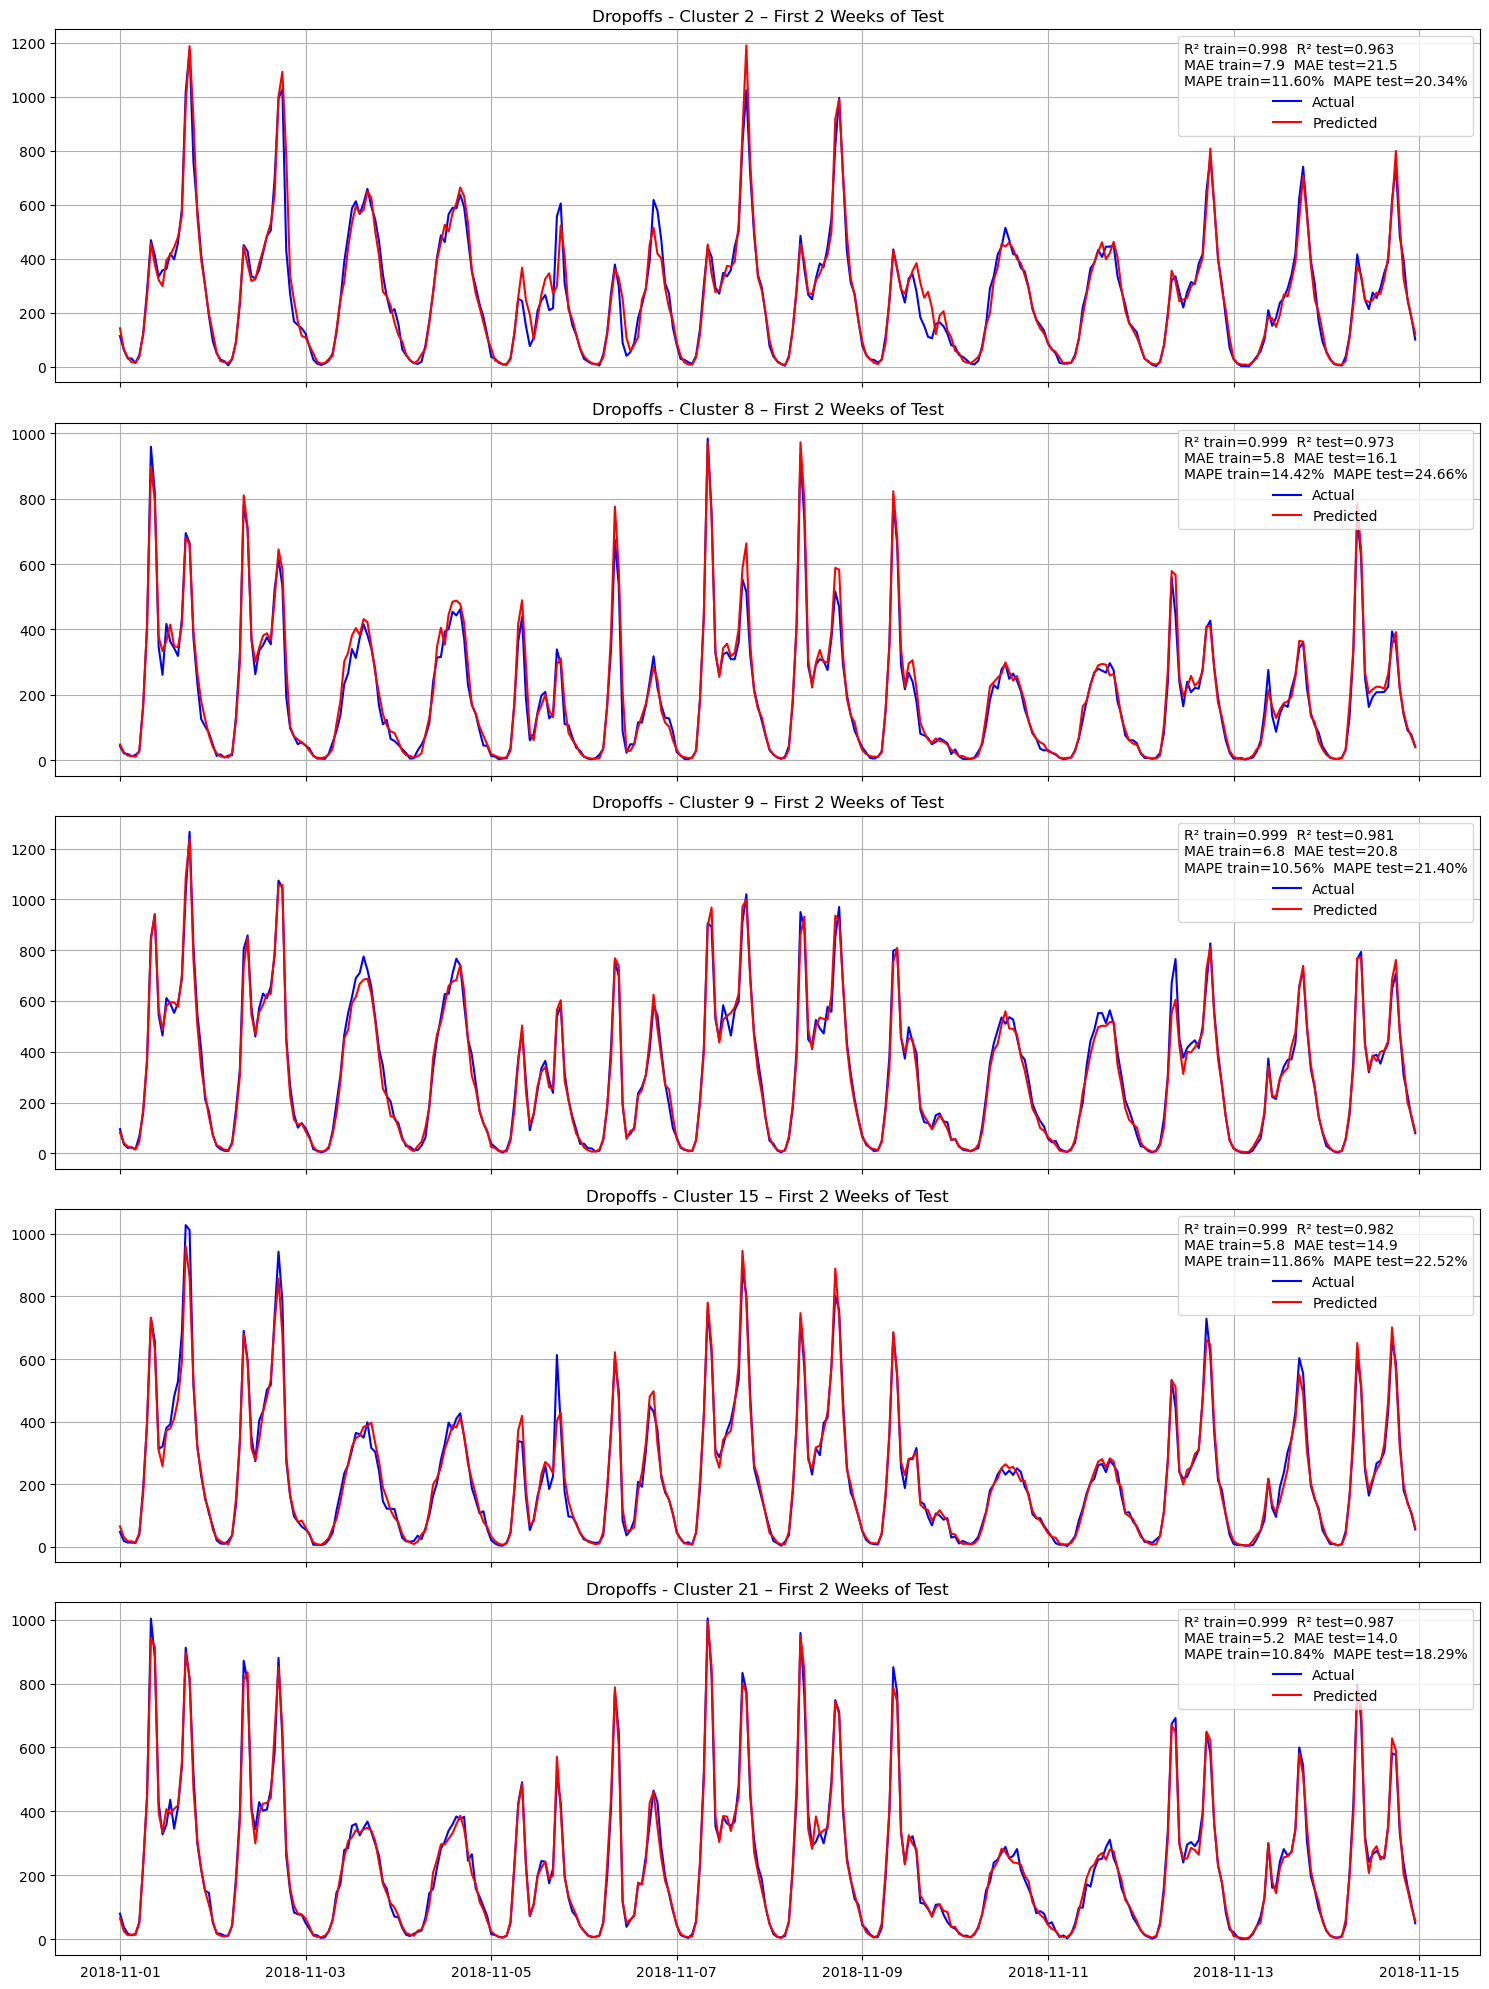

In [53]:
# First 2-week window
start_date = dropoff_test.index.get_level_values('timestamp').min()
end_date = start_date + pd.Timedelta(days=14)

fig, axes = plt.subplots(len(clusters), 1, figsize=(15, 4*len(clusters)), sharex=True)

for i, cluster in enumerate(clusters):
    
    df_test = dropoff_test.xs(cluster, level='end_cluster')
    df_two_weeks = df_test.loc[(df_test.index >= start_date) & (df_test.index < end_date)]
    
    pred_series = pd.Series(
        lgb_predictions_test_drop[cluster],
        index=df_test.index
    ).loc[df_two_weeks.index]
    
    axes[i].plot(df_two_weeks.index, df_two_weeks['count'], label="Actual", color="blue")
    axes[i].plot(df_two_weeks.index, pred_series, label="Predicted", color="red")
    
    # Add metrics in legend
    m = lgb_metrics_drop[cluster]
    axes[i].legend(title=(
        f"R² train={m['r2_train']:.3f}  R² test={m['r2_test']:.3f}\n"
        f"MAE train={m['mae_train']:.1f}  MAE test={m['mae_test']:.1f}\n"
        f"MAPE train={m['mape_train']:.2%}  MAPE test={m['mape_test']:.2%}"
    ))
    
    axes[i].set_title(f"Dropoffs - Cluster {cluster} – First 2 Weeks of Test")
    axes[i].grid(True)

plt.tight_layout()
plt.show()


3) Overnight, the bike-sharing company manually repositions its bikes to ensure that
demand for the next day can be met. You are expected to use the outputs from the
prediction model above to compute the required number of bicycles to be placed in
each cluster of stations analyzed in Task 2 at the beginning of the next day. To
compute this number, you can use the cumulative of the arrivals and departures. The
goal is to ensure that, over the duration of the next day, there will never be a shortage
of bikes – or, if there is, the goal is to minimize the number of bikes in deficit. The
number of bicycles required can be estimated by extrapolating the maximum
difference between the number of departures and arrivals.

In [78]:
# Build prediction DataFrames

# PICKUPS
pickup_pred_df = []
for cluster in lgb_predictions_test:
    df_test = pickup_test.xs(cluster, level="start_cluster").copy()
    df_test["predicted_pickups"] = lgb_predictions_test[cluster]
    df_test["cluster"] = cluster
    pickup_pred_df.append(df_test)

pickup_pred_df = pd.concat(pickup_pred_df)
pickup_pred_df = pickup_pred_df.reset_index().set_index(["timestamp", "cluster"])

# DROPOFFS
drop_pred_df = []
for cluster in lgb_predictions_test_drop:
    df_test = dropoff_test.xs(cluster, level="end_cluster").copy()
    df_test["predicted_dropoffs"] = lgb_predictions_test_drop[cluster]
    df_test["cluster"] = cluster
    drop_pred_df.append(df_test)

drop_pred_df = pd.concat(drop_pred_df)
drop_pred_df = drop_pred_df.reset_index().set_index(["timestamp", "cluster"])

In [79]:
pred_df = pickup_pred_df[["predicted_pickups"]].join(
    drop_pred_df[["predicted_dropoffs"]],
    how="outer"
).fillna(0)


In [80]:
pred_df.head()

predicted_pickups  predicted_dropoffs
timestamp  cluster                                       
2018-11-01 2               104.214802          142.800745
           8                38.259643           48.017927
           9                93.155416           81.455905
           15               48.046055           65.879157
           21               47.352974           65.847982

In [81]:
pred_df["net_flow"] = pred_df["predicted_dropoffs"] - pred_df["predicted_pickups"]

In [76]:
pred_df.head()

predicted_pickups  predicted_dropoffs   net_flow
timestamp  cluster                                                  
2018-11-01 2               104.214802          142.800745  38.585943
           8                38.259643           48.017927   9.758284
           9                93.155416           81.455905 -11.699511
           15               48.046055           65.879157  17.833103
           21               47.352974           65.847982  18.495009

In [ ]:
# pred_df = pred_df.reset_index()
# pred_df["date"] = pred_df["timestamp"].dt.date
# pred_df = pred_df.set_index(["timestamp", "cluster"])


In [82]:
pred_df["date"] = pred_df.index.get_level_values("timestamp").date

def compute_daily_cumulative(group):
    group = group.sort_index()
    group["cumulative_flow"] = group["net_flow"].cumsum()
    return group

pred_df = pred_df.groupby(["cluster", "date"]).apply(compute_daily_cumulative)


/var/folders/5w/sdj24sln3fvfc9dpydspvk380000gn/T/ipykernel_12280/1634520453.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pred_df = pred_df.groupby(["cluster", "date"]).apply(compute_daily_cumulative)


In [83]:
pred_df = pred_df.droplevel("date")


In [84]:
required_bikes = (
    pred_df.groupby(["cluster", "date"])["cumulative_flow"]
           .min()
           .apply(lambda x: max(0, -x))
           .rename("required_initial_bikes")
)

In [86]:
required_bikes.head(10)

cluster  date      
2        2018-11-01    1050.894109
         2018-11-02    1116.373431
         2018-11-03     546.790119
         2018-11-04     426.751265
         2018-11-05     919.283107
         2018-11-06     962.392145
         2018-11-07    1017.945956
         2018-11-08    1138.389594
         2018-11-09    1067.665871
         2018-11-10     377.278155
Name: required_initial_bikes, dtype: float64

In [90]:
pred_df.head(24)

predicted_pickups  predicted_dropoffs  \
cluster timestamp           cluster                                          
2       2018-11-01 00:00:00 2               104.214802          142.800745   
        2018-11-01 01:00:00 2                50.799367           65.255856   
        2018-11-01 02:00:00 2                27.980692           34.675361   
        2018-11-01 03:00:00 2                16.002435           16.790674   
        2018-11-01 04:00:00 2                17.701457           16.167370   
        2018-11-01 05:00:00 2                50.035177           35.960379   
        2018-11-01 06:00:00 2               224.688634          121.638957   
        2018-11-01 07:00:00 2               490.441914          259.693207   
        2018-11-01 08:00:00 2               962.881370          457.208394   
        2018-11-01 09:00:00 2               585.212625          380.322255   
        2018-11-01 10:00:00 2               341.153359          321.706954   
        2018-11-01 11:00:00 2               331.481005          299.478574   
        2018-11-01 12:00:00 2               387.244439          394.457761   
        2018-11-01 13:00:00 2               385.989743          413.649981   
        2018-11-01 14:00:00 2               418.275493          442.965967   
        2018-11-01 15:00:00 2               417.238051          480.336031   
        2018-11-01 16:00:00 2               486.945519          559.713786   
        2018-11-01 17:00:00 2               646.563209          973.467783   
        2018-11-01 18:00:00 2               833.890155         1187.439880   
        2018-11-01 19:00:00 2               574.874838          919.317972   
        2018-11-01 20:00:00 2               423.813489          559.207499   
        2018-11-01 21:00:00 2               319.829793          395.265207   
        2018-11-01 22:00:00 2               265.157588          300.142319   
        2018-11-01 23:00:00 2               185.640976          195.780192   

                                       net_flow        date  cumulative_flow  
cluster timestamp           cluster                                           
2       2018-11-01 00:00:00 2         38.585943  2018-11-01        38.585943  
        2018-11-01 01:00:00 2         14.456490  2018-11-01        53.042433  
        2018-11-01 02:00:00 2          6.694669  2018-11-01        59.737102  
        2018-11-01 03:00:00 2          0.788239  2018-11-01        60.525342  
        2018-11-01 04:00:00 2         -1.534087  2018-11-01        58.991254  
        2018-11-01 05:00:00 2        -14.074798  2018-11-01        44.916457  
        2018-11-01 06:00:00 2       -103.049677  2018-11-01       -58.133221  
        2018-11-01 07:00:00 2       -230.748707  2018-11-01      -288.881928  
        2018-11-01 08:00:00 2       -505.672975  2018-11-01      -794.554903  
        2018-11-01 09:00:00 2       -204.890370  2018-11-01      -999.445273  
        2018-11-01 10:00:00 2        -19.446405  2018-11-01     -1018.891678  
        2018-11-01 11:00:00 2        -32.002431  2018-11-01     -1050.894109  
        2018-11-01 12:00:00 2          7.213322  2018-11-01     -1043.680787  
        2018-11-01 13:00:00 2         27.660238  2018-11-01     -1016.020550  
        2018-11-01 14:00:00 2         24.690474  2018-11-01      -991.330076  
        2018-11-01 15:00:00 2         63.097980  2018-11-01      -928.232095  
        2018-11-01 16:00:00 2         72.768268  2018-11-01      -855.463828  
        2018-11-01 17:00:00 2        326.904574  2018-11-01      -528.559254  
        2018-11-01 18:00:00 2        353.549726  2018-11-01      -175.009529  
        2018-11-01 19:00:00 2        344.443134  2018-11-01       169.433605  
        2018-11-01 20:00:00 2        135.394010  2018-11-01       304.827615  
        2018-11-01 21:00:00 2         75.435414  2018-11-01       380.263029  
        2018-11-01 22:00:00 2         34.984731  2018-11-01       415.247760  
        2018-11-01 23:00:00 2    

In [ ]:
# PLot 